In [2]:
import open3d as o3d
import os
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from PIL import Image

np.random.seed(42)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
o3d.__version__

'0.17.0'

In [4]:
#Note: This is the output produced by using PV_RCNN model to detect objects and not actual labels of objects from KITTI dataset
df= pd.read_csv("/home/user/DATA/Ubuntu_Files/RAP/Direc/VoxelNeXt/OpenPCDet/tools/Kitti_preds/pv_rcnn/Testing/Velodyne/000005.csv")
df

,pos_x,pos_y,pos_z,Length,Width,Height,rot_y,pred_scores,pred_labels
0,7.897598,-2.872000,-0.829342,3.480638,1.604177,1.556609,6.282529,0.994949,Car
1,16.775621,-2.887743,-0.729025,3.686452,1.585005,1.549639,6.320302,0.994017,Car
2,4.376908,6.370239,-0.923336,4.529327,1.809358,1.690168,1.550767,0.979412,Car
3,12.326323,-2.842060,-0.795048,3.422552,1.591734,1.578444,6.344423,0.978355,Car
4,11.263772,6.350885,-0.744036,4.277165,1.759785,1.896608,4.696838,0.972392,Car
5,21.455269,-2.864516,-0.663375,3.700998,1.611603,1.530270,6.323002,0.970681,Car
6,2.266994,-2.878280,-0.976186,3.817983,1.619267,1.459822,6.255680,0.954698,Car
7,1.338921,6.584757,-0.909248,4.161699,1.728683,1.701409,4.771125,0.919583,Car
8,31.875299,13.909501,-0.905358,3.960757,1.572726,1.420109,2.983614,0.845458,Car
9,48.217213,17.894783,-0.909629,3.867751,1.575089,1.403189,2.380365,0.836775,Car


Visualizing 3D bounding boxes of Detected Objects with respect to Velodyne Coordinates using Open3D

In [5]:
# Create a 3D coordinate frame
frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=0.6, origin=[0, 0, 0])

size=len(df)

boxes=[]

for i in range(0, size):
    
    x= df['pos_x'][i] #Note: Had to do some convertions here as the coordinate system of Open3D is different from what is used in Velodyne data of KITTI Dataset
    y=df['pos_z'][i]
    z=-(df['pos_y'][i])

    l=df['Length'][i]
    w=df['Width'][i]
    h=df['Height'][i]

    rot_y=df['rot_y'][i]

    label=df['pred_labels'][i]

    bbox_corners = np.array([
        [x-l/2, y-h/2, z-w/2],
        [x+l/2, y-h/2, z-w/2],
        [x+l/2, y-h/2, z+w/2],
        [x-l/2, y-h/2, z+w/2],
        [x-l/2, y+h/2, z-w/2],
        [x+l/2, y+h/2, z-w/2],
        [x+l/2, y+h/2, z+w/2],
        [x-l/2, y+h/2, z+w/2],
    ])

    lines = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # bottom square
        [4, 5], [5, 6], [6, 7], [7, 4],  # top square
        [0, 4], [1, 5], [2, 6], [3, 7]   # vertical lines
    ]

    # Create a line set for the bounding box
    bbox = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(bbox_corners),
    lines=o3d.utility.Vector2iVector(lines),
    )

    # Create a rotation matrix for a 45 degree rotation about the y-axis
    rotation_matrix = bbox.get_rotation_matrix_from_xyz((0, rot_y, 0))

    # Apply the rotation to the box
    bbox.rotate(rotation_matrix, center=(x, y, z))

    boxes.append(bbox)

o3d.visualization.draw_geometries(boxes+[frame])





##### Projection of 3D Bounding Boxes of Detected Objects onto 2D image

In [6]:
test_img = cv2.imread('/home/user/DATA/Ubuntu_Files/RAP/Direc/VoxelNeXt/OpenPCDet/data/kitti/testing/image_2/000005.png')


Original Image from KITTI corresponding to Velodyne point cloud data used previously

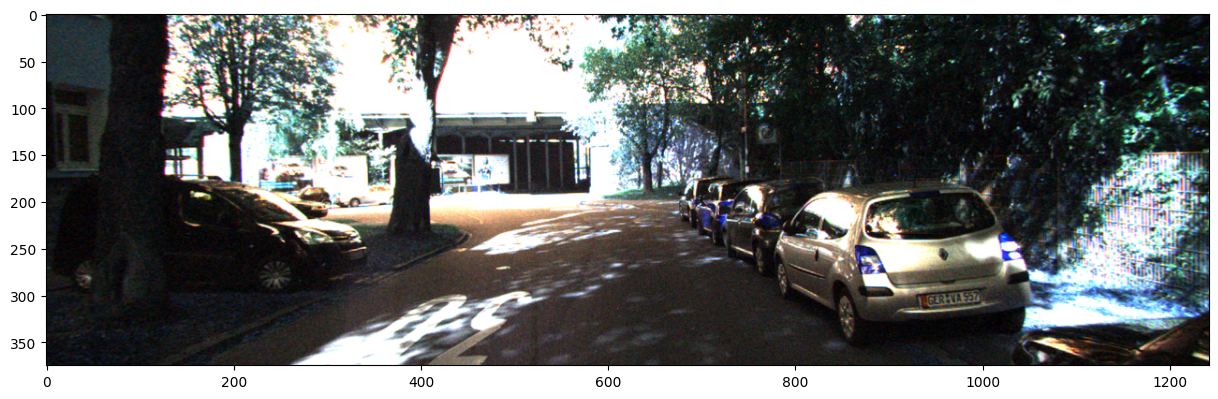

In [7]:
%matplotlib inline
plt.figure(figsize=(15,8))
plt.imshow(test_img)

In [8]:
#Loading calibration matrix from KITTI Dataset
calib = pd.read_csv('/home/user/DATA/Ubuntu_Files/RAP/Direc/VoxelNeXt/OpenPCDet/data/kitti/testing/calib/000005.txt', delimiter=' ', header=None, index_col=0)
calib

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
P0:,721.537700,0.000000,609.559300,0.000000,0.000000,721.537700,172.854000,0.000000,0.000000,0.000000,1.000000,0.000000
P1:,721.537700,0.000000,609.559300,-387.574400,0.000000,721.537700,172.854000,0.000000,0.000000,0.000000,1.000000,0.000000
P2:,721.537700,0.000000,609.559300,44.857280,0.000000,721.537700,172.854000,0.216379,0.000000,0.000000,1.000000,0.002746
P3:,721.537700,0.000000,609.559300,-339.524200,0.000000,721.537700,172.854000,2.199936,0.000000,0.000000,1.000000,0.002730
R0_rect:,0.999924,0.009838,-0.007445,-0.009870,0.999942,-0.004278,0.007403,0.004352,0.999963,NaN,NaN,NaN
Tr_velo_to_cam:,0.007534,-0.999971,-0.000617,-0.004070,0.014802,0.000728,-0.999890,-0.076316,0.999862,0.007524,0.014808,-0.271781
Tr_imu_to_velo:,0.999998,0.000755,-0.002036,-0.808676,-0.000785,0.999890,-0.014823,0.319556,0.002024,0.014825,0.999888,-0.799723


In [9]:
P2 = np.array(calib.loc['P2:']).reshape((3,4))
k1, r1, t1, _, _, _, _ = cv2.decomposeProjectionMatrix(P2)
Tr = np.array(calib.loc['Tr_velo_to_cam:']).reshape((3,4))
R0 = np.array(calib.loc['R0_rect:'])[:9].reshape((3,3))

image = cv2.imread('/home/user/DATA/Ubuntu_Files/RAP/Direc/VoxelNeXt/OpenPCDet/data/kitti/testing/image_2/000005.png')

def rotate_points_around_center(points, centre, yaw_angle):
    
    # Define the rotation matrix for yaw (rotation around z-axis)
    cos_yaw = np.cos(yaw_angle)
    sin_yaw = np.sin(yaw_angle)

    R_yaw = np.array([
        [cos_yaw, -sin_yaw, 0],
        [sin_yaw, cos_yaw, 0],
        [0, 0, 1]
    ])
    
    # Compute the center of the object
    center = centre
    
    # Translate the points so that the center is at the origin
    points_centered = points - center
    
    # Rotate the centered points
    rotated_points_centered = np.dot(R_yaw, points_centered)
    
    # Translate the points back to the original position
    rotated_points = rotated_points_centered + center
    
    return rotated_points

for i in range(0, 13):

    x= df['pos_x'][i] #Note: Here, we can directly use the coordinates from KITTI and there is no need to do the convertions as done in cell 4
    y=df['pos_y'][i]
    z=df['pos_z'][i]

    l=df['Length'][i]
    w=df['Width'][i]
    h=df['Height'][i]

    rot_y=df['rot_y'][i]

    bbox_corners = np.array([
            [x-l/2, y-w/2, z-h/2],
            [x+l/2, y-w/2, z-h/2],
            [x+l/2, y-w/2, z+h/2],
            [x-l/2, y-w/2, z+h/2],
            [x-l/2, y+w/2, z-h/2],
            [x+l/2, y+w/2, z-h/2],
            [x+l/2, y+w/2, z+h/2],
            [x-l/2, y+w/2, z+h/2],
        ])

    points=[]

    for i in bbox_corners:

        rotated_points = rotate_points_around_center(i, [x, y, z], rot_y)
        points.append(rotated_points)


    vertices=[]

    for i in points:

        # Convert R0_rect to 4x4 matrix
        R0_rect_4x4 = np.hstack([R0, np.zeros((3, 1))])
        R0_rect_4x4 = np.vstack([R0_rect_4x4, np.array([0, 0, 0, 1])])

        # Point in Velodyne coordinates
        P_velo = np.array([i[0], i[1], i[2]])

        # Transform to homogeneous coordinates
        P_homo_velo = np.append(P_velo, 1)

        # Transform to unrectified camera coordinates
        Tr_4x4 = np.vstack([Tr, np.array([0, 0, 0, 1])])
        P_cam_unrect = np.dot(Tr_4x4, P_homo_velo)


        # Rectify the camera coordinates
        P_cam_rect = np.dot(R0_rect_4x4, P_cam_unrect)

        # Project onto image plane
        P_image = np.dot(P2, P_cam_rect)

        # Convert to pixel coordinates
        u = P_image[0] / P_image[2]
        v = P_image[1] / P_image[2]

        print(f"The point in image coordinates is at ({u}, {v})")

        u = int(round(P_image[0] / P_image[2]))
        v = int(round(P_image[1] / P_image[2]))

        vertices.append([u,v])

        # Draw the point on the image
        color = (0, 255, 0) # Color of the point (red in BGR format)
        radius = 3 # Radius of the circle
        cv2.circle(image, (u, v), radius, color, -1) # -1 fills the circle

    lines = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # bottom face
        [4, 5], [5, 6], [6, 7], [7, 4],  # top face
        [0, 4], [1, 5], [2, 6], [3, 7]   # vertical lines
    ]

    for line in lines:
        start = tuple(vertices[line[0]])
        end = tuple(vertices[line[1]])
        color = (0, 255, 255)  # Green color in BGR
        thickness = 2
        cv2.line(image, start, end, color, thickness)


# Display the image
cv2.imshow('Image with Points', image)
cv2.waitKey(0)
cv2.destroyAllWindows()


The point in image coordinates is at (1070.307003842065, 364.31239946858864)
The point in image coordinates is at (899.0413669238628, 295.85031160452894)
The point in image coordinates is at (897.2718818355872, 175.73813746518113)
The point in image coordinates is at (1067.0178467215171, 172.98802609366237)
The point in image coordinates is at (873.069460956155, 366.35589473664146)
The point in image coordinates is at (775.2349740687876, 297.14241888196835)
The point in image coordinates is at (773.6807352459305, 177.04405010680216)
The point in image coordinates is at (870.3260377147627, 175.06655243777718)
The point in image coordinates is at (797.5722188266792, 248.80792709748377)
The point in image coordinates is at (754.5086552723977, 235.13855046456547)
The point in image coordinates is at (753.7381741879315, 174.24547731116726)
The point in image coordinates is at (796.5610980881512, 172.63296722957523)
The point in image coordinates is at (720.1489482743027, 249.90816789515546)

Output image with projected 3D bounding boxes of detected objects

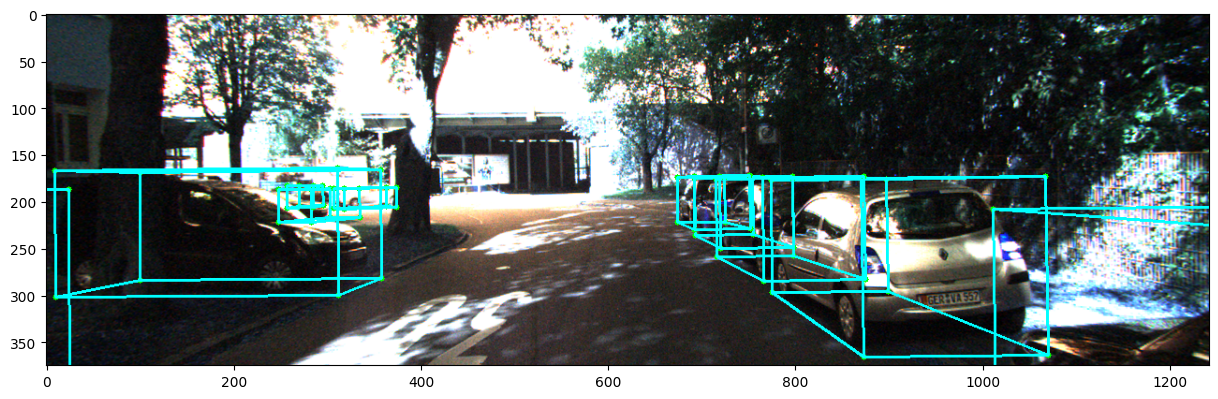

In [10]:
%matplotlib inline
plt.figure(figsize=(15,8))
plt.imshow(image)

In [13]:
cv2.imwrite("/home/user/DATA/Ubuntu_Files/RAP/Direc/VoxelNeXt/OpenPCDet/tools/image_5_output.png", image)

True